In [34]:
# Import libraries
import numpy as np
import pandas as pd

In [35]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.metrics import mean_absolute_error
print(tf.__version__)

2.0.0


In [36]:
# Read datasets
dataset = pd.read_csv('ion_entact_pos.csv')
dataset = dataset.select_dtypes([np.number])

In [37]:
# Rhow dataframe column names
dataset.columns.values

array(['mean_RT', 'n_Repeated_Hits', 'DTXSID_Isomer', 'Observed_Isomer',
       'Isomer_Number', 'Isomer_Order', 'Questionable_Hit',
       'Corrected_HighConc', 'Corrected_MidConc', 'Corrected_LowConc',
       'mean_High_Intensity', 'mean_Mid_Intensity', 'mean_Low_Intensity',
       'std_High_Intensity', 'std_Mid_Intensity', 'std_Low_Intensity',
       'RF_HighConc', 'RF_MedConc', 'RF_LowConc', 'RF_Average', 'E QSPR',
       'S QSPR', 'A QSPR', 'B QSPR', 'V', 'L QSPR', 'MW', 'Ncharges', 'C',
       'Cl', 'N', 'O', 'S', 'F', 'P', 'H', 'Br', 'Si', 'I', 'RNH2',
       'R2NH', 'R3N', 'ROPO3', 'ROH', 'RCHO', 'RCOR', 'RCOOH', 'RCOOR',
       'ROR', 'RCCH', 'RCN', 'RINGS', 'AROMATIC', 'log_RF_Average'],
      dtype=object)

In [38]:
# Assign X and y variables
X = dataset.loc[:, 'E QSPR':'AROMATIC'].values
y = dataset.loc[:, 'log_RF_Average'].values

In [39]:
# y-randomization step -  use only for y-randomization analyis (to use remove '#')
#from sklearn.utils import shuffle
#y = shuffle(y, random_state=1)

In [40]:
# Split dataframe into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

In [41]:
# Normalize data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [42]:
# Compile the ANN model
def build_model():
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(100, activation='exponential'),
    keras.layers.Dense(1)
  ])

  optimizer = tf.optimizers.Adamax(0.001)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 33)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               3400      
_________________________________________________________________
dense_12 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_16 (Dense)             (None, 100)              

In [43]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

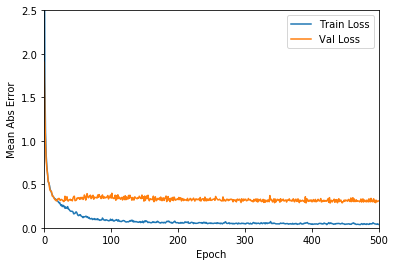

In [44]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.legend()
plt.ylim([0, 2.5])
plt.xlim([0, 500])
plt.show()
#fig.savefig('train_val_entact_500_20.png', dpi=400)


....................................................................................................
....................................................................................................
....................................................................................................
.....................................................

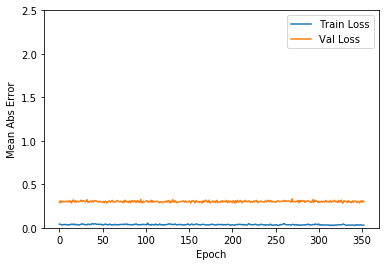

In [46]:
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)

history = model.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.legend()
plt.ylim([0, 2.5])
plt.show()
#fig.savefig('train_val_entact_20.png', dpi=400)

In [47]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1))

Testing set Mean Abs Error:    0.34


In [48]:
[loss, mae] = model.evaluate(X_train, y_train, verbose=0)

print("Training set Mean Abs Error: {:7.2f}".format(mae * 1))

Training set Mean Abs Error:    0.09


In [49]:
# Use model to predict data for training set
from sklearn import metrics

y_pred = model.predict(X_train).flatten()

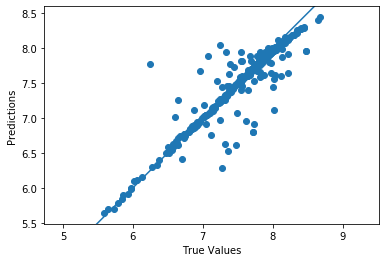

In [50]:
plt.scatter(y_train, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

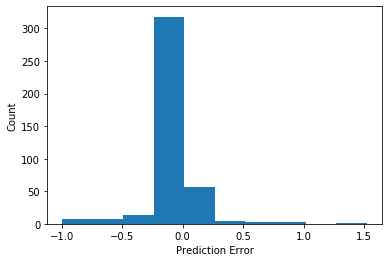

In [51]:
error = y_pred - y_train
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [52]:
# Export data into a dataframe
import pandas as pd
df = pd.DataFrame({'true_values':y_train,'predicted_values':y_pred})
print(df.head())

   true_values  predicted_values
0         7.60          7.589157
1         6.82          6.836970
2         7.70          7.703543
3         5.86          5.901812
4         6.02          6.095643


In [548]:
# Print data to a csv file
df.to_csv('ANN_plus_tr_1.csv')

In [53]:
from sklearn.metrics import r2_score
r2_score(y_train, y_pred)

0.8638148069527253

In [55]:
# Use model to make predictions for the testing set
y_pred = model.predict(X_test).flatten()

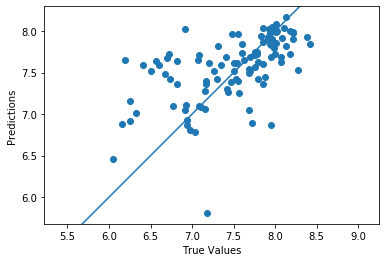

In [56]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

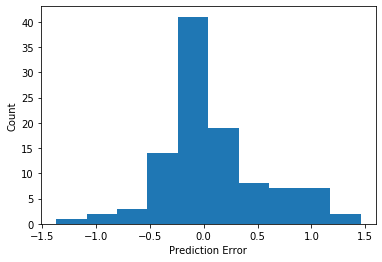

In [57]:
error = y_pred - y_test
plt.hist(error, bins = 10)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

In [58]:
# Export data into a dataframe
df = pd.DataFrame({'true_values':y_test,'predicted_values':y_pred})
print(df.head())

   true_values  predicted_values
0         8.01          8.080698
1         7.95          7.692387
2         7.96          8.044372
3         8.13          8.163337
4         7.62          7.647668


In [554]:
# Print dataframe
df.to_csv('ANN_plus_ts_1.csv')

In [59]:
r2_score(y_test, y_pred)

0.28982235141951496

In [60]:
#Summarize results into one csv file
ts1 = pd.read_csv('ANN_plus_ts_1.csv')
ts2 = pd.read_csv('ANN_plus_ts_2.csv')
ts3 = pd.read_csv('ANN_plus_ts_3.csv')
ts4 = pd.read_csv('ANN_plus_ts_4.csv')
ts5 = pd.read_csv('ANN_plus_ts_5.csv')
ts = pd.concat([ts1,ts2,ts3,ts4,ts5], axis=0)

tr1 = pd.read_csv('ANN_plus_tr_1.csv')
tr2 = pd.read_csv('ANN_plus_tr_2.csv')
tr3 = pd.read_csv('ANN_plus_tr_3.csv')
tr4 = pd.read_csv('ANN_plus_tr_4.csv')
tr5 = pd.read_csv('ANN_plus_tr_5.csv')
tr = pd.concat([tr1,tr2,tr3,tr4,tr5], axis=0)

ts.to_csv('ANN_plus_ts.csv')
tr.to_csv('ANN_plus_tr.csv')

"\nts1 = pd.read_csv('ANN_plus_ts_1.csv')\nts2 = pd.read_csv('ANN_plus_ts_2.csv')\nts3 = pd.read_csv('ANN_plus_ts_3.csv')\nts4 = pd.read_csv('ANN_plus_ts_4.csv')\nts5 = pd.read_csv('ANN_plus_ts_5.csv')\nts = pd.concat([ts1,ts2,ts3,ts4,ts5], axis=0)\n\ntr1 = pd.read_csv('ANN_plus_tr_1.csv')\ntr2 = pd.read_csv('ANN_plus_tr_2.csv')\ntr3 = pd.read_csv('ANN_plus_tr_3.csv')\ntr4 = pd.read_csv('ANN_plus_tr_4.csv')\ntr5 = pd.read_csv('ANN_plus_tr_5.csv')\ntr = pd.concat([tr1,tr2,tr3,tr4,tr5], axis=0)\n\nts.to_csv('ANN_plus_ts.csv')\ntr.to_csv('ANN_plus_tr.csv')"